In [27]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[10,8]
from statsmodels.stats.outliers_influence import variance_inflation_factor
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tools.eval_measures import rmse

# import various functions from scipy
from scipy import stats
from scipy.stats import shapiro

# 'metrics' from sklearn is used for evaluating the model performance
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
import numpy as np

In [2]:
#loading dataset
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('submit.csv')

In [3]:
train.head()

,No,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,AQI
0,1,-16,-4.0,1020.0,SE,1.79,0,0,129
1,2,-15,-4.0,1020.0,SE,2.68,0,0,148
2,3,-11,-5.0,1021.0,SE,3.57,0,0,159
3,4,-7,-5.0,1022.0,SE,5.36,1,0,181
4,5,-7,-5.0,1022.0,SE,6.25,2,0,138


In [4]:
#shape
print(f' shape of training data : {train.shape}')
print(f' shape of test data : {test.shape}')
print(f' shape of submission data : {submission.shape}')

 shape of training data : (41757, 9)
 shape of test data : (8352, 9)
 shape of submission data : (8352, 2)


In [5]:
#checking data types
print('Training Dataset\n')
print(train.info())

print('\ntest Dataset\n')
print(test.info())

Training Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      41757 non-null  int64  
 1   DEWP    41757 non-null  int64  
 2   TEMP    41757 non-null  float64
 3   PRES    41757 non-null  float64
 4   cbwd    41757 non-null  object 
 5   Iws     41757 non-null  float64
 6   Is      41757 non-null  int64  
 7   Ir      41757 non-null  int64  
 8   AQI     41757 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 2.9+ MB
None

test Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8352 entries, 0 to 8351
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      8352 non-null   int64  
 1   DEWP    8352 non-null   int64  
 2   TEMP    8352 non-null   float64
 3   PRES    8352 non-null   int64  
 4   cbwd    8352 non-null   object 
 5   Iws     8352 no

In [6]:
#checking for null values
print('Training Dataset\n')
print(train.isna().sum())

print('\ntest Dataset\n')
print(test.isna().sum())

Training Dataset

No      0
DEWP    0
TEMP    0
PRES    0
cbwd    0
Iws     0
Is      0
Ir      0
AQI     0
dtype: int64

test Dataset

No         0
DEWP       0
TEMP       0
PRES       0
cbwd       0
Iws        0
Is         0
Ir         0
AQI     8352
dtype: int64


In [7]:
test.drop(columns='AQI', axis=1,inplace=True)

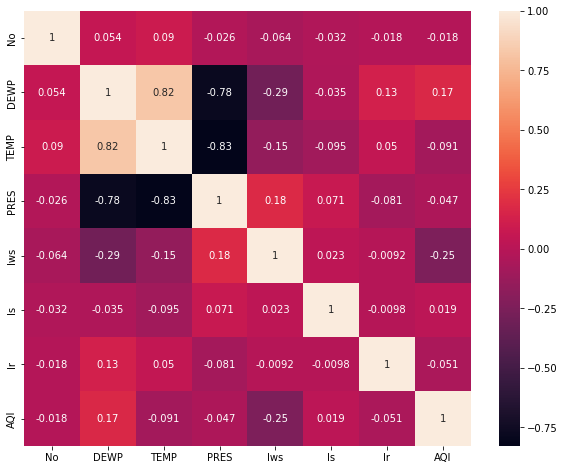

In [8]:
#basic eda to understand the data
sns.heatmap(train.corr(),annot=True)
plt.show()

In [9]:
#dealing with multicollinearity by using vif
df2=train.select_dtypes(include='number')

In [10]:
for ind in range(len(df2.columns)):
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(df2.values, i) for i in range(df2.shape[1])]
    vif["Features"] = df2.columns

In [11]:
vif

,VIF_Factor,Features
0,4.062095,No
1,4.300158,DEWP
2,7.933824,TEMP
3,10.549604,PRES
4,1.429377,Iws
5,1.022555,Is
6,1.062805,Ir
7,2.774494,AQI


we can see presure has highest vif factor if we set the thresold value to 10. we can remove presure for which remaining feature will explain 90 percent variation.
Thresold value can be set according to the business requirement.

In [12]:
#
train.drop('No',axis=1,inplace=True)

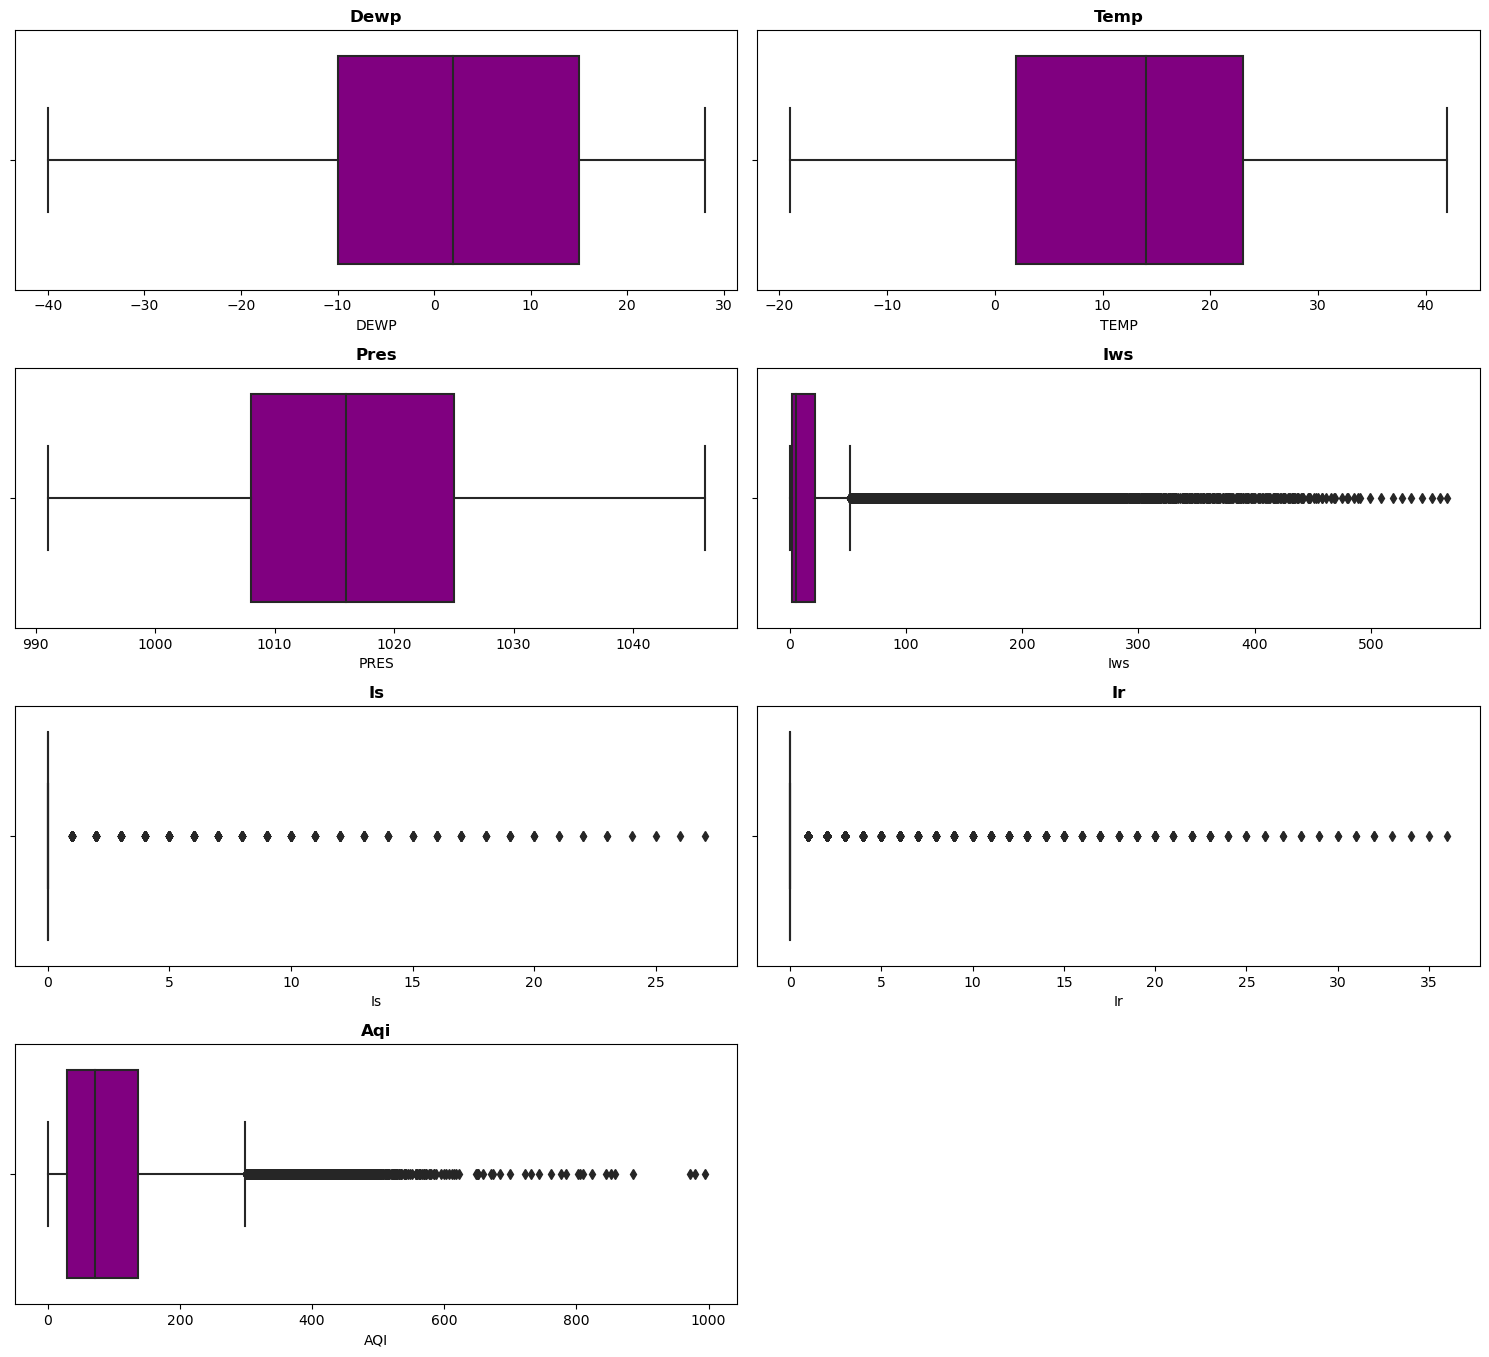

In [13]:
#checking for outliers by visualisizing boxplot
plt.figure(figsize=(15,20),dpi=100)
n=1
for i in train.describe().columns:
    plt.subplot(6,2,n)
    n+=1
    sns.boxplot(train[i],color='purple',saturation=2)
    plt.title(f'{i.title()}',weight='bold')
    plt.tight_layout()

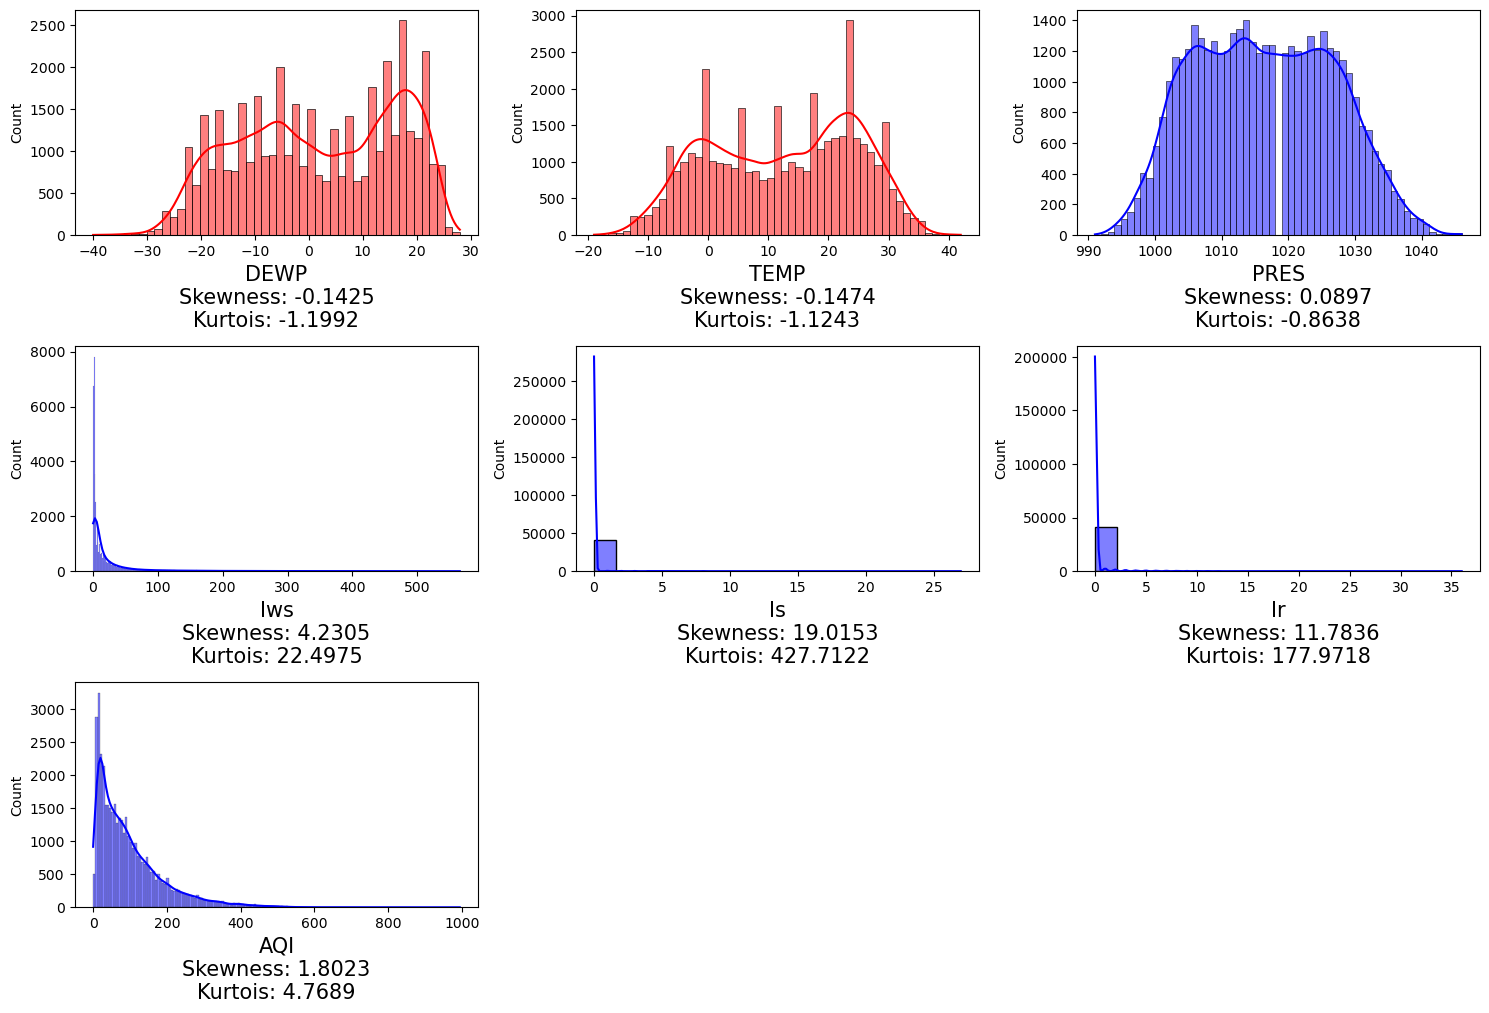

In [14]:
#checking skewness and normallity of data by visualizing graphs
plt.figure(figsize=(15,16),dpi=100)
n=1
for i in train.describe().columns:
    plt.subplot(5,3,n)
    n+=1
    if train[i].skew() < 0 :
        sns.histplot(train[i] ,color='red',kde=True)
        plt.xlabel(f"{i}\nSkewness: {round(train[i].skew(),4)}\nKurtois: {round(train[i].kurt(),4)}",fontsize=15)
    else:
        sns.histplot(train[i],color='blue',kde=True)
        plt.xlabel(f"{i}\nSkewness: {round(train[i].skew(),4)}\nKurtois: {round(train[i].kurt(),4)}",fontsize=15)
plt.tight_layout()

In [15]:
le= LabelEncoder()
train['cbwd']=le.fit_transform(train['cbwd'])

In [16]:
test['cbwd']=le.fit_transform(test['cbwd'])

In [38]:
x_train=train.drop('AQI',axis=1)
y_train=train['AQI']
la=LabelEncoder()
pt=PowerTransformer()
pipe=Pipeline((
('lr', LinearRegression()),
))

pipe.fit(x_train,y_train)
print("Training r2")
print(pipe.score(x_train,y_train))

Training r2
0.2515868863644667


In [18]:
test.drop('No',axis=1,inplace=True)

In [19]:
y_test=pipe.predict(test)

In [20]:
submission['AQI']=y_test

In [39]:
y_train

0        129
1        148
2        159
3        181
4        138
        ... 
41752      8
41753     10
41754     10
41755      8
41756     12
Name: AQI, Length: 41757, dtype: int64

In [56]:
from flaml import AutoML
# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 500,  # in seconds
    "metric": 'mae',
    "task": 'regression',

}

# Train with labeled input data
automl.fit(X_train=x_train, y_train=y_train,
           **automl_settings)

[flaml.automl: 12-16 23:59:13] {2599} INFO - task = regression
[flaml.automl: 12-16 23:59:13] {2601} INFO - Data split method: uniform
[flaml.automl: 12-16 23:59:13] {2604} INFO - Evaluation method: cv
[flaml.automl: 12-16 23:59:13] {2726} INFO - Minimizing error metric: mae
[flaml.automl: 12-16 23:59:13] {2870} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 12-16 23:59:13] {3166} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-16 23:59:13] {3296} INFO - Estimated sufficient time budget=1264s. Estimated necessary time budget=9s.
[flaml.automl: 12-16 23:59:13] {3343} INFO -  at 0.2s,	estimator lgbm's best error=64.5617,	best estimator lgbm's best error=64.5617
[flaml.automl: 12-16 23:59:13] {3166} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-16 23:59:14] {3343} INFO -  at 0.3s,	estimator lgbm's best error=64.5617,	best estimator lgbm's best error=64.5617
[flaml.automl: 12-16 23:59:14] {3166} INF

[flaml.automl: 12-16 23:59:31] {3166} INFO - iteration 36, current learner extra_tree
[flaml.automl: 12-16 23:59:32] {3343} INFO -  at 18.4s,	estimator extra_tree's best error=49.3012,	best estimator lgbm's best error=47.6577
[flaml.automl: 12-16 23:59:32] {3166} INFO - iteration 37, current learner rf
[flaml.automl: 12-16 23:59:32] {3343} INFO -  at 19.1s,	estimator rf's best error=48.2497,	best estimator lgbm's best error=47.6577
[flaml.automl: 12-16 23:59:32] {3166} INFO - iteration 38, current learner rf
[flaml.automl: 12-16 23:59:33] {3343} INFO -  at 20.0s,	estimator rf's best error=47.6467,	best estimator rf's best error=47.6467
[flaml.automl: 12-16 23:59:33] {3166} INFO - iteration 39, current learner rf
[flaml.automl: 12-16 23:59:34] {3343} INFO -  at 20.8s,	estimator rf's best error=47.6467,	best estimator rf's best error=47.6467
[flaml.automl: 12-16 23:59:34] {3166} INFO - iteration 40, current learner rf
[flaml.automl: 12-16 23:59:35] {3343} INFO -  at 21.5s,	estimator rf's

[flaml.automl: 12-17 00:00:38] {3343} INFO -  at 84.9s,	estimator xgb_limitdepth's best error=48.0039,	best estimator rf's best error=45.9711
[flaml.automl: 12-17 00:00:38] {3166} INFO - iteration 74, current learner xgboost
[flaml.automl: 12-17 00:00:39] {3343} INFO -  at 85.4s,	estimator xgboost's best error=48.4202,	best estimator rf's best error=45.9711
[flaml.automl: 12-17 00:00:39] {3166} INFO - iteration 75, current learner xgb_limitdepth
[flaml.automl: 12-17 00:00:40] {3343} INFO -  at 86.7s,	estimator xgb_limitdepth's best error=47.8139,	best estimator rf's best error=45.9711
[flaml.automl: 12-17 00:00:40] {3166} INFO - iteration 76, current learner rf
[flaml.automl: 12-17 00:00:44] {3343} INFO -  at 90.4s,	estimator rf's best error=45.9711,	best estimator rf's best error=45.9711
[flaml.automl: 12-17 00:00:44] {3166} INFO - iteration 77, current learner rf
[flaml.automl: 12-17 00:00:59] {3343} INFO -  at 105.7s,	estimator rf's best error=45.9711,	best estimator rf's best error

[flaml.automl: 12-17 00:02:45] {3166} INFO - iteration 110, current learner extra_tree
[flaml.automl: 12-17 00:02:47] {3343} INFO -  at 213.8s,	estimator extra_tree's best error=46.1548,	best estimator rf's best error=45.9711
[flaml.automl: 12-17 00:02:47] {3166} INFO - iteration 111, current learner lgbm
[flaml.automl: 12-17 00:02:49] {3343} INFO -  at 216.2s,	estimator lgbm's best error=47.1252,	best estimator rf's best error=45.9711
[flaml.automl: 12-17 00:02:49] {3166} INFO - iteration 112, current learner xgb_limitdepth
[flaml.automl: 12-17 00:02:57] {3343} INFO -  at 224.2s,	estimator xgb_limitdepth's best error=46.2011,	best estimator rf's best error=45.9711
[flaml.automl: 12-17 00:02:57] {3166} INFO - iteration 113, current learner xgb_limitdepth
[flaml.automl: 12-17 00:03:00] {3343} INFO -  at 226.5s,	estimator xgb_limitdepth's best error=46.2011,	best estimator rf's best error=45.9711
[flaml.automl: 12-17 00:03:00] {3166} INFO - iteration 114, current learner xgb_limitdepth
[

[flaml.automl: 12-17 00:07:36] {3602} INFO - retrain rf for 2.5s
[flaml.automl: 12-17 00:07:36] {3609} INFO - retrained model: RandomForestRegressor(max_features=0.5744573026671392, max_leaf_nodes=7619,
                      n_estimators=147, n_jobs=-1)
[flaml.automl: 12-17 00:07:36] {2901} INFO - fit succeeded
[flaml.automl: 12-17 00:07:36] {2902} INFO - Time taken to find the best model: 51.62107586860657


In [45]:
y_test_rfc=rfc_model.predict(test)

In [46]:
submission['AQI']=y_test_rfc
submission.to_csv('sub2.csv')

In [53]:
#random forest model given by automl
rfc=RandomForestRegressor(max_features=0.5744573026671392, max_leaf_nodes=7619,
                      n_estimators=147, n_jobs=-1)
rfc_model=rfc.fit(x_train,y_train)
print('r2')
print(rfc_model.score(x_train,y_train))

r2
0.861675938199346


In [54]:
y_test_rfc1=rfc_model.predict(test)

In [55]:
submission['AQI']=y_test_rfc1
submission.to_csv('sub3.csv')

In [65]:
#Random forest model
RFC=RandomForestRegressor()
RFC.fit(x_train,y_train)
print(RFC.score(x_train,y_train))

0.9026995007627661


In [67]:
y_test_rfc2=RFC.predict(test)

In [69]:
submission['AQI']=y_test_rfc2
submission.to_csv('sub5.csv')

In [71]:
tuned_paramaters = [{'criterion': ['entropy', 'gini'],
                     'n_estimators': [10, 30, 50, 70, 90,100,110,120,130,150],
                     'max_depth': [5,10, 15, 20,30],
                     'max_features': ['sqrt', 'log2'],
                     'min_samples_split': [2,4,5,6,7,8,10],
                     'min_samples_leaf': [1, 3,4,5, 9],
                     'max_leaf_nodes': [2, 5, 8, 11]}]

random_forest= RandomForestRegressor(random_state = 10)

rf_grid = GridSearchCV(estimator = random_forest, 
                       param_grid = tuned_paramaters, 
                       cv = 5)

# use fit() to fit the model on the train set
rf_grid_model = rf_grid.fit(x_train, y_train)

# get the best parameters
print('Best parameters for random forest classifier: ', rf_grid_model.best_params_, '\n')


KeyboardInterrupt

